<a href="https://colab.research.google.com/github/patdring/QuantumML/blob/main/QuantumNN_IrisClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quantum Machine Learning with Qiskit: Iris Classification Experiment
====================================================================

Overview
--------

This Jupyter notebook demonstrates a quantum machine learning (QML) experiment using Qiskit, a quantum computing framework. The experiment involves classifying a subset of the Iris dataset using a Quantum Neural Network (QNN). This README provides an in-depth explanation of the quantum components and steps involved in the experiment.

Quantum Components Used
-----------------------

1.  **Qiskit Libraries**: Essential libraries from Qiskit are used, including `Aer`, `QuantumCircuit`, `ZZFeatureMap`, `RealAmplitudes`, and `AerSimulator`. These components are pivotal for creating and simulating quantum circuits.
    
2.  **EstimatorQNN**: From `qiskit_machine_learning.neural_networks`, this neural network model is specifically designed for quantum machine learning tasks.
    

Preprocessing and Data Preparation
----------------------------------

*   **Dataset**: The famous Iris dataset is loaded, but only the first 100 samples are used for binary classification.
*   **Standardization**: The data is standardized using `StandardScaler` to have zero mean and unit variance, which is crucial for effective model training.
*   **Dimensionality Reduction**: `PCA` (Principal Component Analysis) is applied to reduce the feature space to 2 dimensions, aiding in visualization and possibly enhancing model performance.

Quantum Circuit Construction
----------------------------

1.  **Feature Map**: A `ZZFeatureMap` is created to encode classical data into quantum states. It's a crucial step in QML, ensuring the classical data can interact with quantum elements.
2.  **Ansatz**: The `RealAmplitudes` ansatz is chosen to form the learnable part of the quantum circuit. This component is akin to the layers in a classical neural network.
3.  **Circuit Composition**: The feature map and ansatz are combined into a single quantum circuit using `QuantumCircuit.compose`.

Quantum Neural Network (QNN) and Training
-----------------------------------------

*   **Initialization**: An `EstimatorQNN` is initialized with the combined circuit, input parameters from the feature map, and weight parameters from the ansatz.
*   **Optimization**: A custom objective function is defined to maximize accuracy. The weights of the ansatz are optimized using the COBYLA method, a numerical optimization algorithm suitable for constrained problems.

Visualization and Results
-------------------------

*   **Decision Boundary**: Post optimization, a decision boundary is visualized using a mesh grid and contour plot. It shows how the QNN classifies the data points in the reduced feature space.
*   **Performance Metrics**: The optimized weights and accuracy of the QNN are printed, providing insights into the model's effectiveness.

Quantum Insights
----------------

This experiment illustrates how quantum computing can be integrated with machine learning. By leveraging quantum states and superposition, QNNs offer a novel approach to data processing and classification, potentially outperforming classical methods in certain scenarios.

In [ ]:
!pip install --upgrade qiskit
!pip install --upgrade qiskit_machine_learning
!pip install --upgrade qiskit-aer

In [ ]:
import qiskit_machine_learning.neural_networks
dir(qiskit_machine_learning.neural_networks)

['EffectiveDimension',
 'EstimatorQNN',
 'LocalEffectiveDimension',
 'NeuralNetwork',
 'SamplerQNN',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'effective_dimension',
 'estimator_qnn',
 'neural_network',
 'sampler_qnn']

Optimized Weights: [1.26489012 0.61348224 0.87289364 0.30474885]
Optimized Accuracy: 0.65


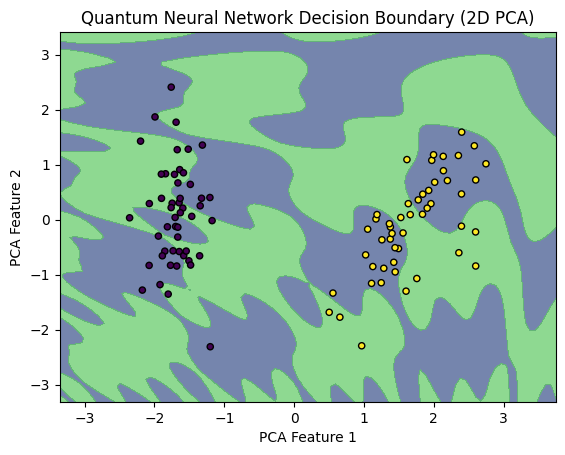

In [ ]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.providers.aer import AerSimulator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load and preprocess the Iris dataset
iris = load_iris()
X, y = iris.data[:100], iris.target[:100]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a feature map
feature_map = ZZFeatureMap(feature_dimension=2, reps=1)

# Create an ansatz
ansatz = RealAmplitudes(2, reps=1)

# Combine the feature map and the ansatz using QuantumCircuit.compose
qc = QuantumCircuit(2)
qc.compose(feature_map, range(2), inplace=True)
qc.compose(ansatz, range(2), inplace=True)

# Define the backend using AerSimulator
backend = AerSimulator()

# Initialize the EstimatorQNN
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

# Randomly initialize weights for the demonstration
random_weights = np.random.rand(ansatz.num_parameters)

# Define a function to optimize (negative accuracy)
def objective_function(weights):
    predicted_labels = []
    for x in X_pca[:80]:
        prediction = qnn.forward(x, weights)[0]
        predicted_label = 1 if prediction > 0.5 else 0
        predicted_labels.append(predicted_label)
    accuracy = accuracy_score(y[:80], predicted_labels)
    # Return the negative accuracy (minimize)
    return -accuracy

# Define bounds and initial guess for weights
bounds = [(0, 2*np.pi)] * ansatz.num_parameters  # Example bounds for weights
initial_guess = random_weights  # Example initial guess

# Run the optimization
result = minimize(objective_function, initial_guess, bounds=bounds, method='COBYLA', options={'maxiter': 500, 'disp': False})

optimal_weights = result.x
optimized_accuracy = -result.fun  # Convert back to positive accuracy

print(f"Optimized Weights: {optimal_weights}")
print(f"Optimized Accuracy: {optimized_accuracy}")

# Create a mesh grid for visualization
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Flatten the grid for prediction
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict each point on the grid using the optimized weights
Z = np.array([qnn.forward(point, optimal_weights)[0] for point in grid])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.7, levels=np.linspace(Z.min(), Z.max(), 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k', s=20)

plt.title("Quantum Neural Network Decision Boundary (2D PCA)")
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()
